In [1]:
import pandas as pd

# Load the dataset to inspect its structure
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      504 non-null    object 
 1   Rainfall  504 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.0+ KB


(         Date  Rainfall
 0  1981-01-01      0.00
 1  1981-02-01      0.00
 2  1981-03-01      1.29
 3  1981-04-01      7.30
 4  1981-05-01      7.74,
 None)

In [2]:
def create_lagged_features(data, n_lags=3):
    """
    Creates lagged features for time series forecasting.
    Args:
        data: The time series data.
        n_lags: The number of lagged observations to include as features.
    Returns:
        A DataFrame with lagged features.
    """
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, n_lags + 1)]
    columns.append(df)
    df_lagged = pd.concat(columns, axis=1)
    df_lagged.columns = ['Lag'+str(i) for i in range(n_lags, 0, -1)] + ['Target']
    df_lagged.dropna(inplace=True)
    return df_lagged

# Apply lagged feature creation on the rainfall data
n_lags = 3  # Number of lagged timesteps to use as input
df_lagged = create_lagged_features(df['Rainfall'].values, n_lags)

# Split the lagged dataset into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(df_lagged))
train, test = df_lagged[:train_size], df_lagged[train_size:]

# Define X (features) and y (target) for training and testing
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]


In [3]:
# Convert 'Date' column to datetime and check for any missing values
df['Date'] = pd.to_datetime(df['Date'])

# Check if there are any missing values
missing_data = df.isnull().sum()

# Sort the dataframe by Date to ensure it is time-ordered
df = df.sort_values(by='Date')

# Display basic statistics and check if sorting worked properly
df.describe(), missing_data, df.head()


(                                Date    Rainfall
 count                            504  504.000000
 mean   2001-12-15 23:02:51.428571392   10.070794
 min              1981-01-01 00:00:00    0.000000
 25%              1991-06-23 12:00:00    0.267500
 50%              2001-12-16 12:00:00    4.580000
 75%              2012-06-08 12:00:00   16.435000
 max              2022-12-01 00:00:00   60.810000
 std                              NaN   12.202849,
 Date        0
 Rainfall    0
 dtype: int64,
         Date  Rainfall
 0 1981-01-01      0.00
 1 1981-02-01      0.00
 2 1981-03-01      1.29
 3 1981-04-01      7.30
 4 1981-05-01      7.74)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define the feature (date as index) and target (rainfall)
df.set_index('Date', inplace=True)
X = df.index
y = df['Rainfall'].values

# Split into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = df.index[:train_size], df.index[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# For models like ANN, SVR, and LSTM, scaling is recommended
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

# Summary of data split
{
    "train_size": len(X_train),
    "test_size": len(X_test),
    "train_data_range": (X_train[0], X_train[-1]),
    "test_data_range": (X_test[0], X_test[-1]),
}


{'train_size': 403,
 'test_size': 101,
 'train_data_range': (Timestamp('1981-01-01 00:00:00'),
  Timestamp('2014-07-01 00:00:00')),
 'test_data_range': (Timestamp('2014-08-01 00:00:00'),
  Timestamp('2022-12-01 00:00:00'))}

<h1>SVR</h1>

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....C=10, epsilon=0.01, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .......C=10, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.2s
[CV] END .......C=10, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.2s
[CV] END .......C=10, epsilon=0.01, gamma=scale, kernel=poly; total time=   0.2s
[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........C=10, epsilon=0.01, gamma=aut

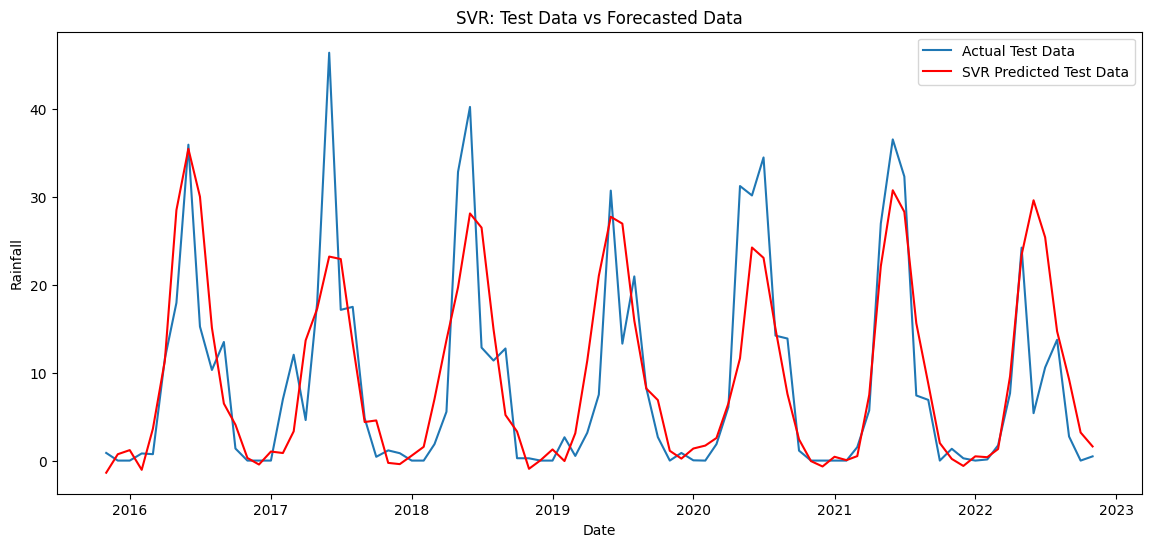

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(rainfall_data) * 0.8)
train_data = rainfall_data[:train_size]  # Training data
test_data = rainfall_data[train_size:]  # Testing data

# Fit the scaler ONLY on the training data and transform both datasets
scaled_train_data = scaler.fit_transform(train_data)  # Fit and transform training data
scaled_test_data = scaler.transform(test_data)       # Transform testing data using the same scaler

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 15

# Create training and testing sequences
X_train, y_train = create_sequences(scaled_train_data, time_step)
X_test, y_test = create_sequences(scaled_test_data, time_step)

# ---- GRIDSEARCHCV FOR HYPERPARAMETER TUNING ---- #
param_grid = {
    'C': [10, 100, 1000],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Use the best model to make predictions
test_predict = best_model.predict(X_test)
train_predict = best_model.predict(X_train)

# Inverse transform the predictions and actual values to their original scale
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))  # Predicted values for test
y_test_actual = scaler.inverse_transform([y_test])                   # Actual test values

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))  # Predicted values for train
y_train_actual = scaler.inverse_transform([y_train])                   # Actual train values

# Calculate Train Metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
train_mae = mean_absolute_error(y_train_actual[0], train_predict[:, 0])
train_r2 = r2_score(y_train_actual[0], train_predict[:, 0])
non_zero_indices_train = y_train_actual[0] != 0
train_mape = np.mean(np.abs((y_train_actual[0][non_zero_indices_train] - train_predict[:, 0][non_zero_indices_train]) / y_train_actual[0][non_zero_indices_train])) * 100

# Calculate Test Metrics
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:, 0])
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])
non_zero_indices_test = y_test_actual[0] != 0
test_mape = np.mean(np.abs((y_test_actual[0][non_zero_indices_test] - test_predict[:, 0][non_zero_indices_test]) / y_test_actual[0][non_zero_indices_test])) * 100

# Print Train Metrics
print(f"SVR Train RMSE: {train_rmse}")
print(f"SVR Train R²: {train_r2:.2f}")
print(f"SVR Train MAE: {train_mae}")
print(f"SVR Train MAPE: {train_mape:.2f}%")

# Print Test Metrics
print(f"SVR Test RMSE: {test_rmse}")
print(f"SVR Test R²: {test_r2:.2f}")
print(f"SVR Test MAE: {test_mae}")
print(f"SVR Test MAPE: {test_mape:.2f}%")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(scaled_test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='SVR Predicted Test Data', color='red')
plt.title('SVR: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


<h1>ANN</h1>

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0825
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0381 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━

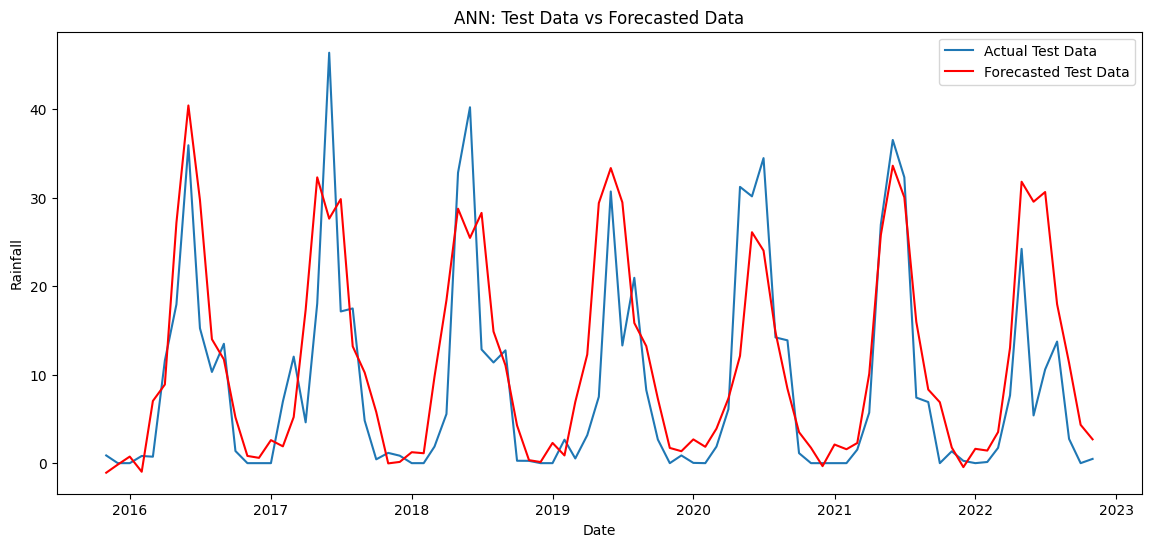

In [6]:
## import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Added r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load your dataset (replace 'your_data.csv' with the path to your dataset)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 15

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)
          
# Build the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=time_step))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1)

# Predict on the test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Calculate RMSE, MAE, and MAPE
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
train_mae = mean_absolute_error(y_train_actual[0], train_predict[:, 0])
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:, 0])
non_zero_indices = y_test_actual[0] != 0
train_mape = np.mean(np.abs((y_train_actual[0][non_zero_indices_train] - train_predict[:, 0][non_zero_indices_train]) / y_train_actual[0][non_zero_indices_train])) * 100
test_mape = np.mean(np.abs((y_test_actual[0][non_zero_indices] - test_predict[:, 0][non_zero_indices]) / y_test_actual[0][non_zero_indices])) * 100

# Calculate R-squared for train and test data
train_r2 = r2_score(y_train_actual[0], train_predict[:, 0])
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])

# Print the results
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Train R-squared: {train_r2:.4f}")
print(f"Test R-squared: {test_r2:.4f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict) + time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='Forecasted Test Data', color='red')
plt.title('ANN: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


<H1>CNN</H1>

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0454  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 
Epoch 16/100
6/6 ━━━━━━━━━━━━━

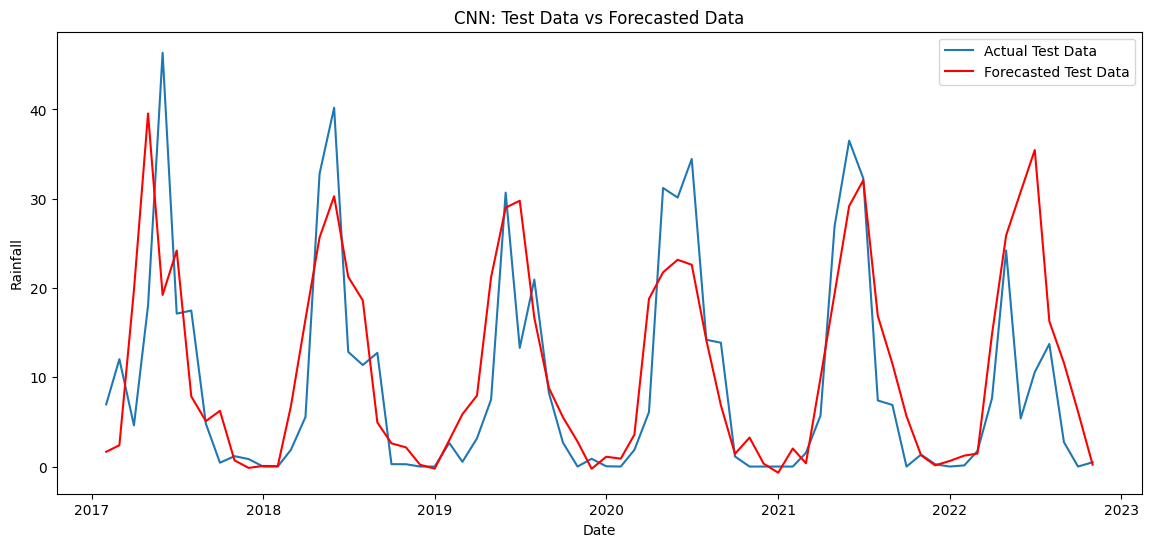

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

# Load your dataset (replace 'your_data.csv' with the path to your dataset)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1)

# Predict on the test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Calculate RMSE, MAE, R², and MAPE for training data
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
train_mae = mean_absolute_error(y_train_actual[0], train_predict[:, 0])
train_r2 = r2_score(y_train_actual[0], train_predict[:, 0])
non_zero_train_indices = y_train_actual[0] != 0
train_mape = np.mean(np.abs((y_train_actual[0][non_zero_train_indices] - train_predict[:, 0][non_zero_train_indices]) / y_train_actual[0][non_zero_train_indices])) * 100

# Calculate RMSE, MAE, R², and MAPE for testing data
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:, 0])
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])
non_zero_test_indices = y_test_actual[0] != 0
test_mape = np.mean(np.abs((y_test_actual[0][non_zero_test_indices] - test_predict[:, 0][non_zero_test_indices]) / y_test_actual[0][non_zero_test_indices])) * 100

# Print all metrics
print(f"Train RMSE: {train_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Train R²: {train_r2}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R²: {test_r2}")
print(f"Test MAPE: {test_mape:.2f}%")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='Forecasted Test Data', color='red')
plt.title('CNN: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


<H1>DT</H1>

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Train RMSE: 1.8029
Train MAE: 1.2576
Train R²: 0.9779
Train MAPE: 109.23% (109.22880064428637)
Test RMSE: 5.4789
Test MAE: 3.3714
Test R²: 0.8099
Test MAPE: 250.64% (250.63631789561106)


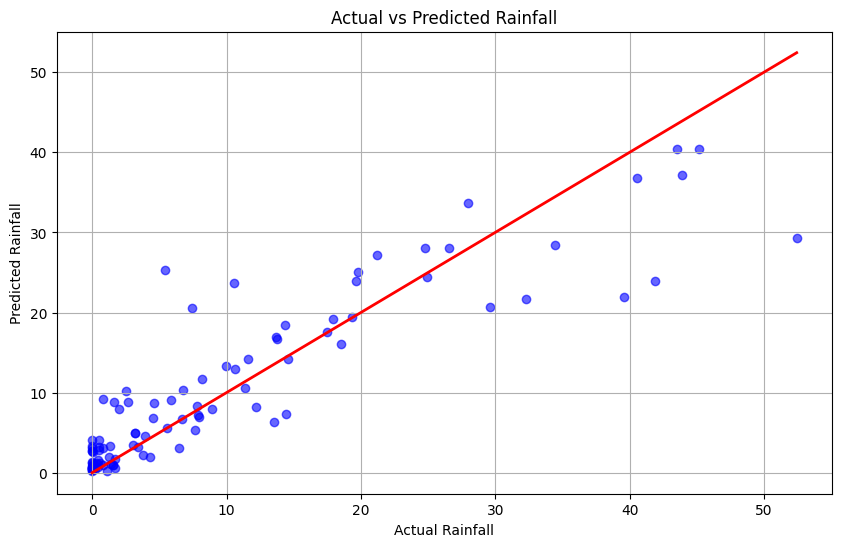

                 Feature  Importance
4              Month_cos    0.250730
1                  Month    0.189302
7         Rainfall_Lag_1    0.175711
11   Rainfall_RollingStd    0.094286
8         Rainfall_Lag_2    0.070035
10  Rainfall_RollingMean    0.068668
3              Month_sin    0.064468
9         Rainfall_Lag_3    0.062317
0                   Year    0.024483
2                    Day    0.000000
5                Day_sin    0.000000
6                Day_cos    0.000000


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your dataset (replace 'your_data.csv' with the path to your dataset)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Data Preparation
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Add cyclical features for Month and Day
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

# Add lag features for rainfall
for i in range(1, 8):  # Lag features for the last 7 days
    df[f'Rainfall_Lag_{i}'] = df['Rainfall'].shift(i)

# Add rolling statistics for rainfall
df['Rainfall_RollingMean'] = df['Rainfall'].rolling(window=7).mean()
df['Rainfall_RollingStd'] = df['Rainfall'].rolling(window=7).std()

# Drop rows with NaN values created due to lag and rolling features
df.dropna(inplace=True)

# Define features (X) and target (y)
X = df[['Year', 'Month', 'Day', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
        'Rainfall_Lag_1', 'Rainfall_Lag_2', 'Rainfall_Lag_3',
        'Rainfall_RollingMean', 'Rainfall_RollingStd']]
y = df['Rainfall']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest model
model = RandomForestRegressor(random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['1.0', 'sqrt', 'log2']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the Random Forest model with the best hyperparameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Function to calculate MAPE safely
def calculate_mape(y_true, y_pred):
    # Avoid division by zero by excluding zeros from the calculation
    non_zero_mask = y_true != 0
    if np.any(non_zero_mask):
        return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    else:
        return np.inf

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = calculate_mape(y_train, y_train_pred)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = calculate_mape(y_test, y_test_pred)

# Print all metrics
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Train MAPE: {train_mape:.2f}% ({train_mape})")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.2f}% ({test_mape})")


# Visualize Actual vs Predicted Rainfall
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Rainfall')
plt.ylabel('Predicted Rainfall')
plt.title('Actual vs Predicted Rainfall')
plt.grid(True)
plt.show()

# Feature Importance Analysis
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(importance_df.sort_values(by='Importance', ascending=False))


<H1>RF</H1>

Train RMSE: 2.3167
Train MAE: 1.4858
Train R²: 0.9640
Train MAPE: 90.26% (90.2645471052949)
Test RMSE: 7.0970
Test MAE: 4.9017
Test R²: 0.6390
Test MAPE: 203.41% (203.4091550934513)


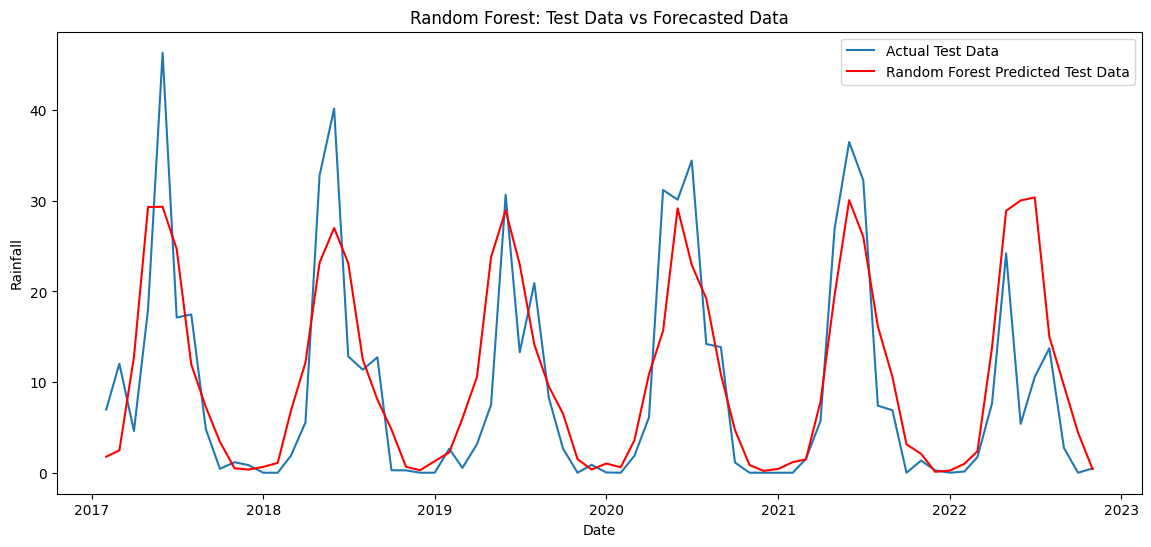

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your dataset (replace 'your_data.csv' with the path to your dataset)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Build and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict on the train and test data
y_train_pred = rf_model.predict(X_train)
test_predict = rf_model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_test_actual = scaler.inverse_transform([y_test])

# Calculate RMSE, MAE, R², and MAPE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train_actual := scaler.inverse_transform([y_train])[0], y_train_pred[:, 0]))
train_mae = mean_absolute_error(y_train_actual, y_train_pred[:, 0])
train_r2 = r2_score(y_train_actual, y_train_pred[:, 0])

# Handle zero values in y_train for MAPE calculation
train_non_zero_indices = y_train_actual != 0
train_mape = np.mean(np.abs((y_train_actual[train_non_zero_indices] - y_train_pred[:, 0][train_non_zero_indices]) / y_train_actual[train_non_zero_indices])) * 100

test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:, 0])
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])

# Handle zero values in y_test for MAPE calculation
non_zero_indices = y_test_actual[0] != 0
test_mape = np.mean(np.abs((y_test_actual[0][non_zero_indices] - test_predict[:, 0][non_zero_indices]) / y_test_actual[0][non_zero_indices])) * 100

# Print all metrics
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Train MAPE: {train_mape:.2f}% ({train_mape})")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.2f}% ({test_mape})")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='Random Forest Predicted Test Data', color='red')
plt.title('Random Forest: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


#### LSTM

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0625 - val_loss: 0.0443
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0428 - val_loss: 0.0385
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0429 - val_loss: 0.0378
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0412 - val_loss: 0.0372
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0352 - val_loss: 0.0362
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0383 - val_loss: 0.0342
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0370 - val_loss: 0.0325
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0344 - val_loss: 0.0296
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0267 - val_loss: 0.0274
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0233 - val_loss: 0.0255
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0221 - val_loss: 0.0277
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0179 - val_loss: 0.0247


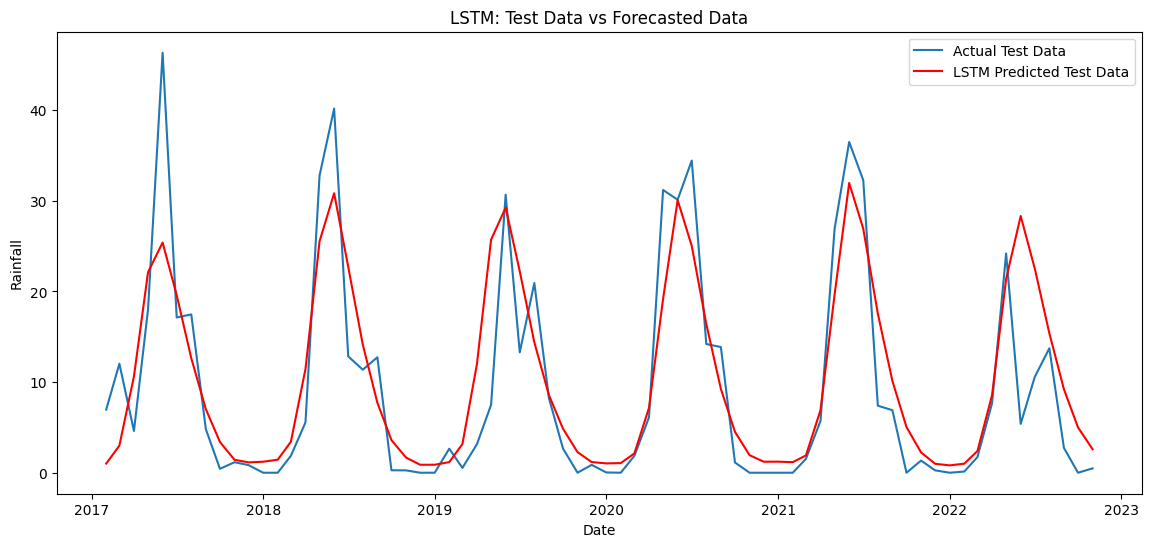

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Load your dataset
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the input to be [samples, time steps, features] which is the format required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout to reduce overfitting
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # Dropout Layer

# Second LSTM layer with Dropout
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))  # Dropout Layer

# Dense layer to map LSTM output to prediction
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict on the training data
train_predict = model.predict(X_train)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])

# Calculate training metrics: RMSE, MAE, MSE, MAPE, and R-squared
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
train_mae = mean_absolute_error(y_train_actual[0], train_predict[:, 0])
train_mse = mean_squared_error(y_train_actual[0], train_predict[:, 0])
train_r2 = r2_score(y_train_actual[0], train_predict[:, 0])
non_zero_train_indices = y_train_actual[0] != 0  # Avoid division by zero
train_mape = np.mean(np.abs((y_train_actual[0][non_zero_train_indices] - train_predict[:, 0][non_zero_train_indices]) / y_train_actual[0][non_zero_train_indices])) * 100

# Print the training results
print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training MSE: {train_mse}")
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Training R-squared: {train_r2:.2f}")

# Predict on the test data
test_predict = model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Calculate test metrics: RMSE, MAE, MAPE, and R-squared
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
test_mse = mean_squared_error(y_test_actual[0], test_predict[:, 0])  # Test MSE calculation
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:, 0])
non_zero_indices = y_test_actual[0] != 0
test_mape = np.mean(np.abs((y_test_actual[0][non_zero_indices] - test_predict[:, 0][non_zero_indices]) / y_test_actual[0][non_zero_indices])) * 100
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])

# Print the test results
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R-squared: {test_r2:.2f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='LSTM Predicted Test Data', color='red')
plt.title('LSTM: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


# Bayesian Linear Regression (BLR)

Bayesian Linear Regression - Training RMSE: 5.840684650544574
Bayesian Linear Regression - Training MAE: 3.919843297825938
Bayesian Linear Regression - Training MAPE: 325.61%
Bayesian Linear Regression - Training R²: 0.77
Bayesian Linear Regression - Test RMSE: 7.048969701333424
Bayesian Linear Regression - Test MAE: 5.006410065896679
Bayesian Linear Regression - Test MAPE: 311.68%
Bayesian Linear Regression - Test R²: 0.64


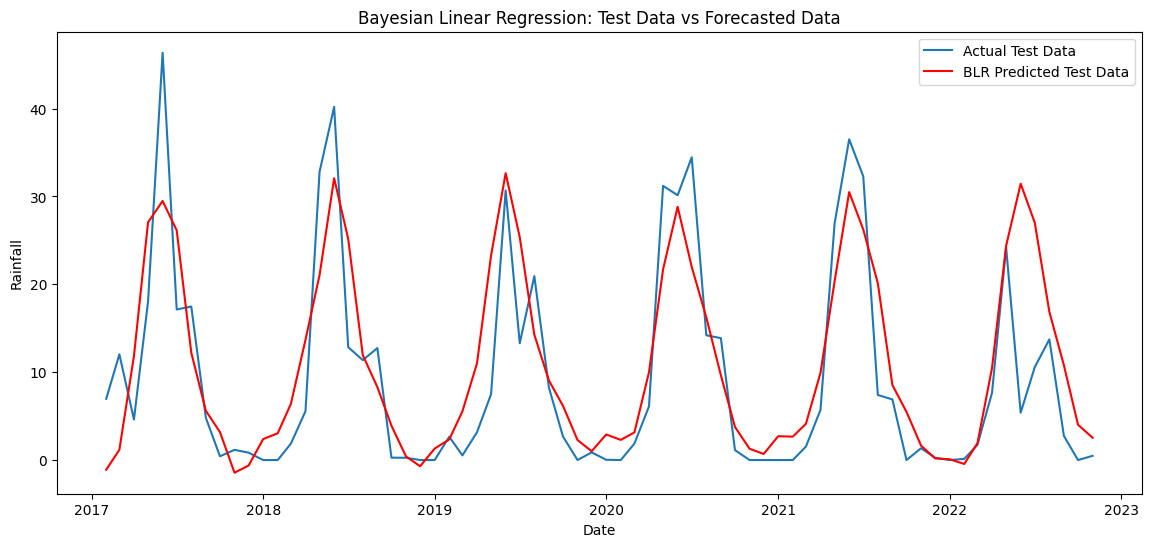

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Fit the Bayesian Linear Regression model
blr_model = BayesianRidge()
blr_model.fit(X_train, y_train)

# Predict on the training data
train_predict = blr_model.predict(X_train)
# Predict on the testing data
test_predict = blr_model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Calculate training metrics: RMSE, MAE, MAPE, and R²
train_rmse = np.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
train_mae = mean_absolute_error(y_train_actual[0], train_predict[:, 0])
train_r2 = r2_score(y_train_actual[0], train_predict[:, 0])
non_zero_train_indices = y_train_actual[0] != 0  # Avoid division by zero
train_mape = np.mean(np.abs((y_train_actual[0][non_zero_train_indices] - train_predict[:, 0][non_zero_train_indices]) / y_train_actual[0][non_zero_train_indices])) * 100

# Print training results
print(f"Bayesian Linear Regression - Training RMSE: {train_rmse}")
print(f"Bayesian Linear Regression - Training MAE: {train_mae}")
print(f"Bayesian Linear Regression - Training MAPE: {train_mape:.2f}%")
print(f"Bayesian Linear Regression - Training R²: {train_r2:.2f}")

# Calculate test metrics: RMSE, MAE, MAPE, and R²
test_rmse = np.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))
test_mae = mean_absolute_error(y_test_actual[0], test_predict[:, 0])
test_r2 = r2_score(y_test_actual[0], test_predict[:, 0])
non_zero_indices = y_test_actual[0] != 0  # Avoid division by zero
test_mape = np.mean(np.abs((y_test_actual[0][non_zero_indices] - test_predict[:, 0][non_zero_indices]) / y_test_actual[0][non_zero_indices])) * 100

# Print testing results
print(f"Bayesian Linear Regression - Test RMSE: {test_rmse}")
print(f"Bayesian Linear Regression - Test MAE: {test_mae}")
print(f"Bayesian Linear Regression - Test MAPE: {test_mape:.2f}%")
print(f"Bayesian Linear Regression - Test R²: {test_r2:.2f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='BLR Predicted Test Data', color='red')
plt.title('Bayesian Linear Regression: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


# Boosted Decision Tree Regression (BDTR)

Boosted Decision Tree Regression - Training RMSE: 1.80278842831866
Boosted Decision Tree Regression - Training MAE: 1.3327422273503802
Boosted Decision Tree Regression - Training MAPE: 116.80%
Boosted Decision Tree Regression - Training R²: 0.98
Boosted Decision Tree Regression - Test RMSE: 7.256429171890996
Boosted Decision Tree Regression - Test MAE: 4.985253335281985
Boosted Decision Tree Regression - Test MAPE: 190.82%
Boosted Decision Tree Regression - Test R²: 0.62


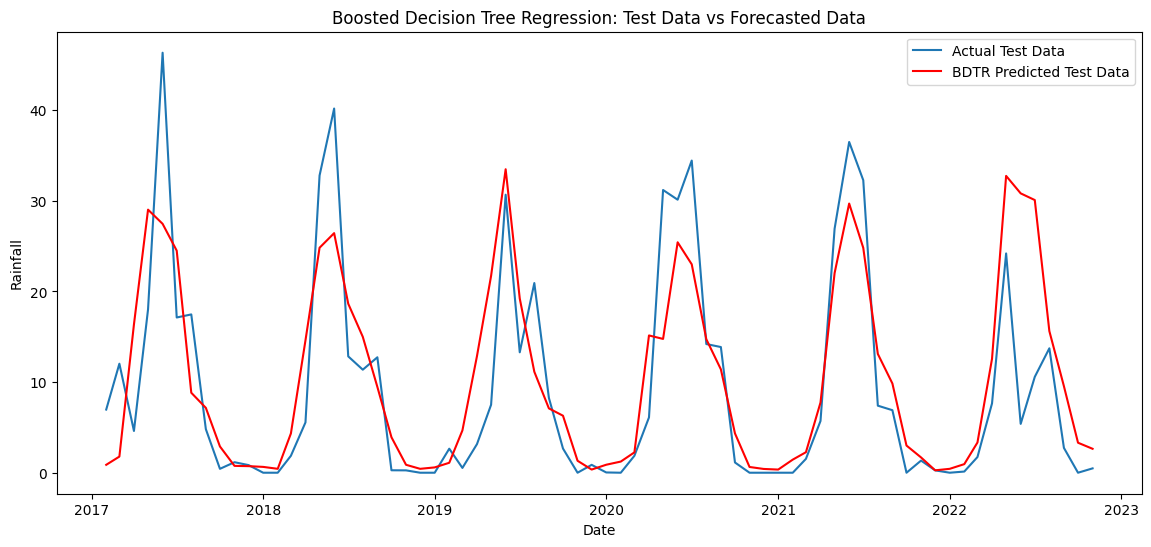

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)  # Reshape to 2D for scaling

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Fit the Boosted Decision Tree Regression model
bdtr_model = GradientBoostingRegressor()  # Instantiate the model
bdtr_model.fit(X_train, y_train)

# Predict on the training data
train_predict = bdtr_model.predict(X_train).reshape(-1, 1)
# Predict on the testing data
test_predict = bdtr_model.predict(X_test).reshape(-1, 1)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate training metrics: RMSE, MAE, MAPE, and R²
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_r2 = r2_score(y_train_actual, train_predict)
non_zero_train_indices = y_train_actual.flatten() != 0  # Avoid division by zero
train_mape = np.mean(np.abs((y_train_actual[non_zero_train_indices] - train_predict[non_zero_train_indices]) / y_train_actual[non_zero_train_indices])) * 100

# Print training results
print(f"Boosted Decision Tree Regression - Training RMSE: {train_rmse}")
print(f"Boosted Decision Tree Regression - Training MAE: {train_mae}")
print(f"Boosted Decision Tree Regression - Training MAPE: {train_mape:.2f}%")
print(f"Boosted Decision Tree Regression - Training R²: {train_r2:.2f}")

# Calculate testing metrics: RMSE, MAE, MAPE, and R²
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_mae = mean_absolute_error(y_test_actual, test_predict)
test_r2 = r2_score(y_test_actual, test_predict)
non_zero_test_indices = y_test_actual.flatten() != 0  # Avoid division by zero
test_mape = np.mean(np.abs((y_test_actual[non_zero_test_indices] - test_predict[non_zero_test_indices]) / y_test_actual[non_zero_test_indices])) * 100

# Print testing results
print(f"Boosted Decision Tree Regression - Test RMSE: {test_rmse}")
print(f"Boosted Decision Tree Regression - Test MAE: {test_mae}")
print(f"Boosted Decision Tree Regression - Test MAPE: {test_mape:.2f}%")
print(f"Boosted Decision Tree Regression - Test R²: {test_r2:.2f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict) + time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='BDTR Predicted Test Data', color='red')
plt.title('Boosted Decision Tree Regression: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


# Random Forest Regression (RFR)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Random Forest Regressor - Training RMSE: 2.22902221260677
Random Forest Regressor - Training MAE: 1.4336451001955037
Random Forest Regressor - Training MAPE: 104.32%
Random Forest Regressor - Training R²: 0.97
Random Forest Regressor - Test RMSE: 6.837479470061529
Random Forest Regressor - Test MAE: 4.80846541125541
Random Forest Regressor - Test MAPE: 196.52%
Random Forest Regressor - Test R²: 0.66


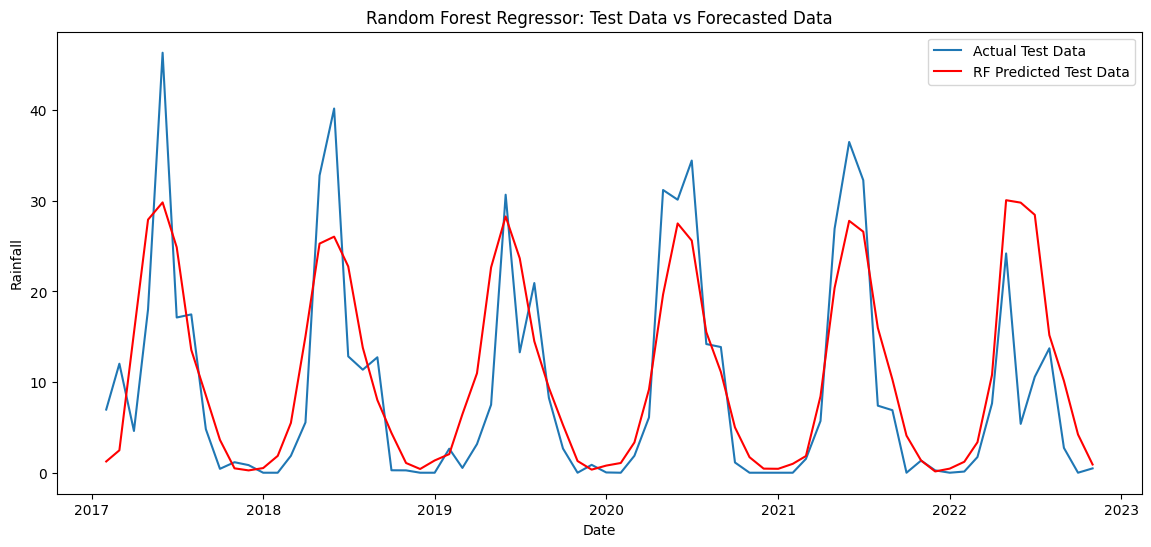

'.'

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset (replace with the actual path)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape for RandomForestRegressor
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum samples required at each leaf node
    'max_features': ['auto', 'sqrt']   # Number of features to consider at each split
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Predict on the training data
train_predict = best_model.predict(X_train).reshape(-1, 1)
# Predict on the test data
test_predict = best_model.predict(X_test).reshape(-1, 1)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate training metrics: RMSE, MAE, MAPE, and R²
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_r2 = r2_score(y_train_actual, train_predict)
non_zero_train_indices = y_train_actual.flatten() != 0  # Avoid division by zero
train_mape = np.mean(np.abs((y_train_actual[non_zero_train_indices] - train_predict[non_zero_train_indices]) / y_train_actual[non_zero_train_indices])) * 100

# Print training results
print(f"Random Forest Regressor - Training RMSE: {train_rmse}")
print(f"Random Forest Regressor - Training MAE: {train_mae}")
print(f"Random Forest Regressor - Training MAPE: {train_mape:.2f}%")
print(f"Random Forest Regressor - Training R²: {train_r2:.2f}")

# Calculate testing metrics: RMSE, MAE, MAPE, and R²
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_mae = mean_absolute_error(y_test_actual, test_predict)
test_r2 = r2_score(y_test_actual, test_predict)
non_zero_test_indices = y_test_actual.flatten() != 0  # Avoid division by zero
test_mape = np.mean(np.abs((y_test_actual[non_zero_test_indices] - test_predict[non_zero_test_indices]) / y_test_actual[non_zero_test_indices])) * 100

# Print testing results
print(f"Random Forest Regressor - Test RMSE: {test_rmse}")
print(f"Random Forest Regressor - Test MAE: {test_mae}")
print(f"Random Forest Regressor - Test MAPE: {test_mape:.2f}%")
print(f"Random Forest Regressor - Test R²: {test_r2:.2f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='RF Predicted Test Data', color='red')
plt.title('Random Forest Regressor: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()
'.'

# Neural Network Regression (NNR)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0566 - val_loss: 0.0398
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0393 - val_loss: 0.0381
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0444 - val_loss: 0.0366
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0380 - val_loss: 0.0349
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0361 - val_loss: 0.0320
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0298 - val_loss: 0.0297
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0282 - val_loss: 0.0245
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0184 - val_loss: 0.0224
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0167 - val_loss: 0.0227
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0140 - val_loss: 0.0214
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0130 - val_loss: 0.0185
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0

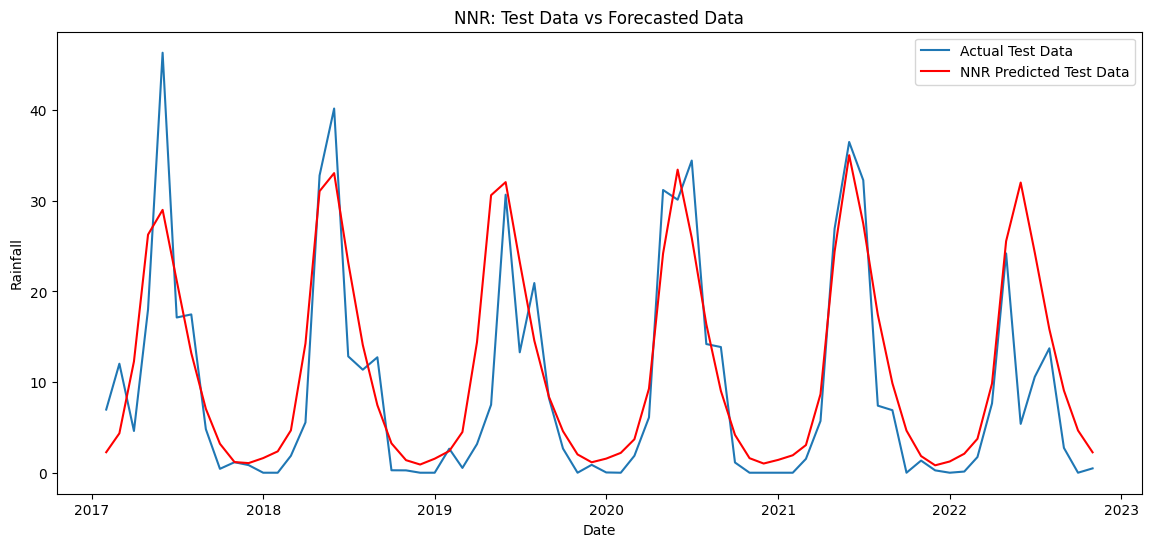

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset (replace with the actual path)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the Neural Network Model (LSTM model to capture temporal patterns)
nn_model = Sequential()
nn_model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
nn_model.add(LSTM(25, return_sequences=False))
nn_model.add(Dense(1))  # Output layer

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Optimizer with adjustable learning rate
nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on the test data
test_predict = nn_model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, and MAPE
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_mae = mean_absolute_error(y_test_actual, test_predict)

# Handling non-zero values to avoid division by zero in MAPE
non_zero_indices = y_test_actual.flatten() != 0
test_mape = np.mean(np.abs((y_test_actual[non_zero_indices] - test_predict[non_zero_indices]) / y_test_actual[non_zero_indices])) * 100

# Calculate R-squared
test_r2 = r2_score(y_test_actual, test_predict)

print(f"NNR Test RMSE: {test_rmse}")
print(f"NNR Test MAE: {test_mae}")
print(f"NNR Test MAPE: {test_mape:.2f}%")
print(f"NNR Test R-squared: {test_r2:.2f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='NNR Predicted Test Data', color='red')
plt.title('NNR: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0496 - val_loss: 0.0428
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0438 - val_loss: 0.0382
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0417 - val_loss: 0.0372
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0388 - val_loss: 0.0347
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0348 - val_loss: 0.0314
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0272 - val_loss: 0.0294
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0236 - val_loss: 0.0254
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0171 - val_loss: 0.0302
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0157 - val_loss: 0.0207
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0142 - val_loss: 0.0203
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0151 - val_loss: 0.0195
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0

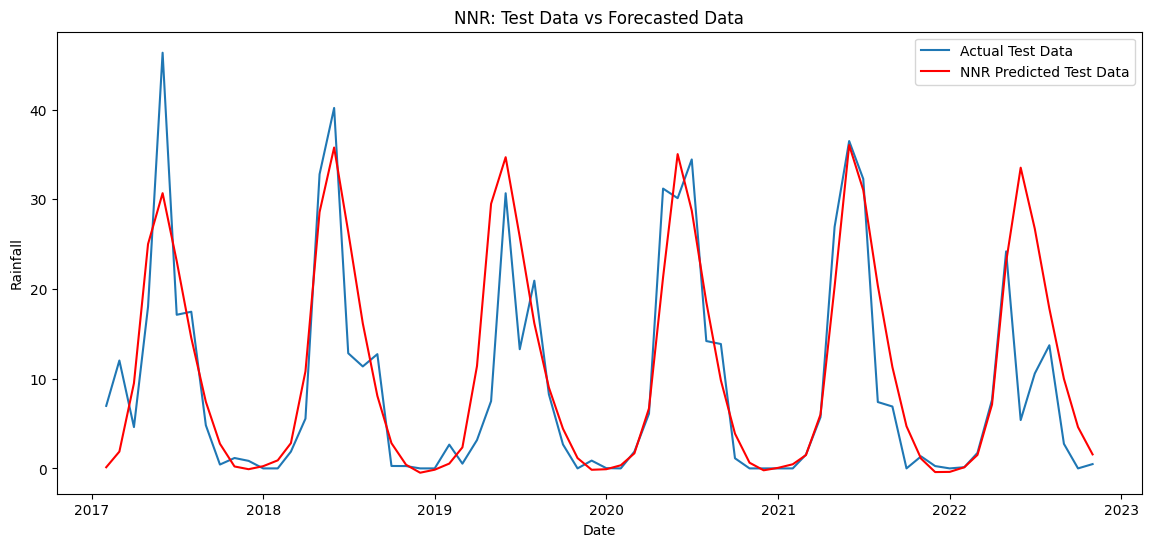

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset (replace with the actual path)
df = pd.read_csv('/kaggle/input/rain-forecast/date_range_1981_to_2022 (1) - date_range_1981_to_2022 (1).csv')

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Extract rainfall values for modeling
rainfall_data = df['Rainfall'].values.reshape(-1, 1)

# Normalize the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rainfall_data)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (how many past days to use for predicting the next day)
time_step = 30

# Create training and testing sequences
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the Neural Network Model (LSTM model to capture temporal patterns)
nn_model = Sequential()
nn_model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
nn_model.add(LSTM(25, return_sequences=False))
nn_model.add(Dense(1))  # Output layer

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Optimizer with adjustable learning rate
nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict on the training data
train_predict = nn_model.predict(X_train)

# Predict on the test data
test_predict = nn_model.predict(X_test)

# Inverse transform the predictions and actual values to their original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate training metrics: RMSE, MAE, MAPE, and R²
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_r2 = r2_score(y_train_actual, train_predict)
non_zero_train_indices = y_train_actual.flatten() != 0  # Avoid division by zero
train_mape = np.mean(np.abs((y_train_actual[non_zero_train_indices] - train_predict[non_zero_train_indices]) / y_train_actual[non_zero_train_indices])) * 100

# Print training results
print(f"NNR Training RMSE: {train_rmse}")
print(f"NNR Training MAE: {train_mae}")
print(f"NNR Training MAPE: {train_mape:.2f}%")
print(f"NNR Training R-squared: {train_r2:.2f}")

# Calculate testing metrics: RMSE, MAE, MAPE, and R²
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_mae = mean_absolute_error(y_test_actual, test_predict)
test_r2 = r2_score(y_test_actual, test_predict)
non_zero_test_indices = y_test_actual.flatten() != 0  # Avoid division by zero
test_mape = np.mean(np.abs((y_test_actual[non_zero_test_indices] - test_predict[non_zero_test_indices]) / y_test_actual[non_zero_test_indices])) * 100

# Print testing results
print(f"NNR Test RMSE: {test_rmse}")
print(f"NNR Test MAE: {test_mae}")
print(f"NNR Test MAPE: {test_mape:.2f}%")
print(f"NNR Test R-squared: {test_r2:.2f}")

# Plot the Test Data vs Forecasted Data
plt.figure(figsize=(14, 6))
test_dates = df.index[len(train_data) + time_step:len(train_data) + time_step + len(test_predict)]
plt.plot(test_dates, scaler.inverse_transform(test_data[time_step:len(test_predict)+time_step]), label='Actual Test Data')
plt.plot(test_dates, test_predict, label='NNR Predicted Test Data', color='red')
plt.title('NNR: Test Data vs Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.show()
